In [ ]:
! pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import collections
import copy
import tqdm
import random
import math
import numpy as np

# Environment constants
INPUTS = 4
ACTIONS = 2
EXPERIENCE_MEM = int(1e5)

# Model architecture
model_layer_sz = [(INPUTS, 128), (128, 64)]
v_layer_sz = [(64, 64), (64, 1)]
a_layer_sz = [(64, 64), (64, ACTIONS)]

# RL hyper-parameters
max_epsilon = 1.0
min_epsilon = 0.05
epsilon_decay = 0.997
batch_sz = 128
gamma = 0.99
tau = 1000
lr = 1e-4
epochs = 4000

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# DQN model
class DQN(nn.Module):
    def __init__(self, model_sz, v_layer_sz, a_layer_sz):
        super().__init__()
        self.model = nn.Sequential(
            *[nn.Linear(x, y) if i % 2 == 0 else nn.ReLU() for x, y in model_sz for i in range(2)]
        )
        self.v = nn.Sequential(
            *[nn.Linear(x, y) if i % 2 == 0 else nn.ReLU() for x, y in v_layer_sz for i in range(2)]
        )
        self.a = nn.Sequential(
            *[nn.Linear(x, y) if i % 2 == 0 else nn.ReLU() for x, y in a_layer_sz for i in range(2)]
        )
        # Remove ReLU activations on last layer
        self.v = self.v[:-1]
        self.a = self.a[:-1]

    def forward(self, inp):
        inter = self.model(inp)
        a = self.a(inter)
        v = self.v(inter)

        return v + (a - torch.mean(a))

In [ ]:
# Define environment for RL agent
import gymnasium as gym

env = gym.make('CartPole-v1', render_mode = "rgb_array")

In [ ]:
# Define memory for experience learning
Experience = collections.namedtuple('Experience', ('cur_state', 'action', 'reward', 'future_state'))
memory = collections.deque(maxlen = EXPERIENCE_MEM)

In [ ]:
# Initialize models and auxillary components
policy_model = DQN(model_layer_sz, v_layer_sz, a_layer_sz).to(device)
target_model = DQN(model_layer_sz, v_layer_sz, a_layer_sz).to(device)
target_model = copy.deepcopy(policy_model)
opt = torch.optim.AdamW(policy_model.parameters(), lr = lr)

In [ ]:
# If loading trained models:
policy_model.load_state_dict(torch.load("/content/gdrive/My Drive/RL_DQN/policy_model.pth"))
target_model.load_state_dict(torch.load("/content/gdrive/My Drive/RL_DQN/target_model.pth"))
opt.load_state_dict(torch.load("/content/gdrive/My Drive/RL_DQN/opt.pth"))

In [ ]:
# Train agent
epoch_steps_graph = []
total_steps = 0

with tqdm.tqdm(total = epochs) as t:
    for i in range(epochs):
        state, _ = env.reset()
        cur_eps = max(math.pow(epsilon_decay, i) * max_epsilon, min_epsilon)
        epoch_steps = 0

        while True:
            epoch_steps += 1
            total_steps += 1
            # Sample new action
            explore_exploit = random.uniform(0, 1)
            if explore_exploit > cur_eps:
                # Exploit
                with torch.no_grad():
                    action = int(torch.argmax(policy_model(torch.tensor(state, device = device)), dim = -1))

            else:
                # Explore
                action = random.randint(0, ACTIONS - 1)
            new_state, reward, terminated, truncated, _ = env.step(action)

            if terminated or truncated:
                new_state = None
            memory.append(Experience(state, action, reward, new_state))
            state = new_state

            if total_steps % tau == 0:
                target_model = copy.deepcopy(policy_model)

            if len(memory) >= batch_sz:
                experiences = random.sample(memory, batch_sz)
                states = []
                rewards = []
                actions = []
                future_states = []
                future_states_none = []

                for idx, i in enumerate(experiences):
                    states.append(i.cur_state)
                    rewards.append(i.reward)
                    actions.append(i.action)
                    if i.future_state is not None:
                        future_states_none.append(idx)
                        future_states.append(i.future_state)

                states = torch.tensor(states, device = device)
                rewards = torch.tensor(rewards, device = device)
                future_states = torch.tensor(future_states, device = device)
                q_val_preds = policy_model(states)
                q_val_future = torch.zeros_like(rewards, device=device, dtype = torch.float32)
                q_val_future_preds = torch.max(target_model(future_states), dim = -1).values
                q_val_future[future_states_none] = q_val_future_preds
                q_val_policy = q_val_preds[torch.arange(len(actions)), actions]
                q_val_target = rewards + gamma * q_val_future
                loss = nn.functional.huber_loss(q_val_policy, q_val_target)
                loss.backward()
                nn.utils.clip_grad_norm_(policy_model.parameters(), 5)
                opt.step()
                policy_model.zero_grad()

            if terminated or truncated:
                epoch_steps_graph.append(epoch_steps)
                break

        t.update(1)

  0%|          | 0/4000 [00:00<?, ?it/s]<ipython-input-16-5ec4b64c280d>:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states = torch.tensor(states, device = device)
 25%|██▌       | 1000/4000 [14:12<42:36,  1.17it/s]  


KeyboardInterrupt: ignored

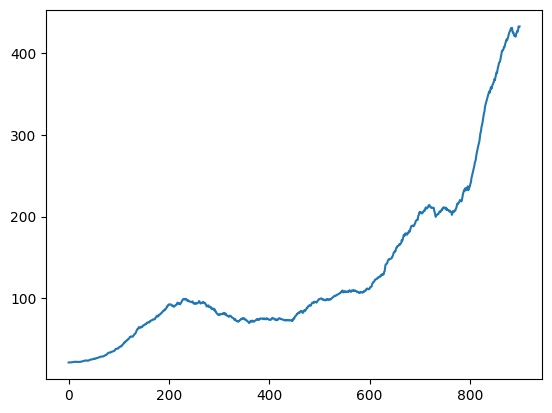

In [ ]:
import matplotlib.pyplot as plt

# Use rolling average to smooth the epoch length graph
rolling_average_len = 100
epoch_steps_graph = np.cumsum(epoch_steps_graph)
epoch_steps_graph = epoch_steps_graph[rolling_average_len:] - epoch_steps_graph[:-rolling_average_len]
epoch_steps_graph = epoch_steps_graph.astype(float) / rolling_average_len

plt.plot(epoch_steps_graph)
plt.show()

Render trained agent performance. Thanks https://ymd_h.gitlab.io/ymd_blog/posts/gym_on_google_colab_with_gnwrapper/ for code on how to render Gymnasium in Google Colab environment.

In [ ]:
!apt update
!apt install xvfb
! pip install pyvirtualdisplay

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [498 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [966 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [993 kB]
Hit:13 https://ppa.l

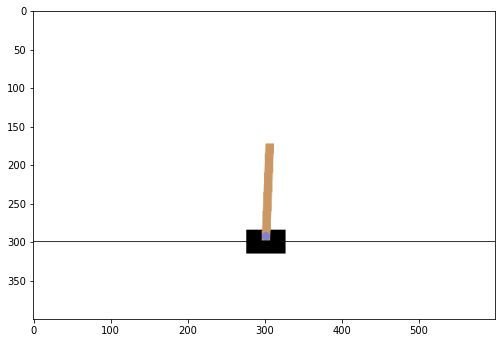

In [ ]:
import gym
from IPython import display
from pyvirtualdisplay import Display
from matplotlib import animation


d = Display()
d.start()

o, _ = env.reset()

img = []
for _ in range(500):
    o, r, d, i, __ = env.step(int(torch.argmax(policy_model(torch.tensor(o, device=device)))))
    display.clear_output(wait=True)
    img.append(env.render())

    if d or i:
        env.reset()

dpi = 72
interval = 50 # ms

plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
patch = plt.imshow(img[0])
plt.axis=('off')
animate = lambda i: patch.set_data(img[i])
ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
display.display(display.HTML(ani.to_jshtml()))

In [ ]:
# Save render of trained agent
ani.save('myAnimation.gif', writer='imagemagick', fps=30)

In [ ]:
# Save model weights to Google Drive for storage
from google.colab import drive
drive.mount('/content/gdrive')

PATH = "/content/gdrive/My Drive/RL_DQN/policy_model.pth"
torch.save(policy_model.state_dict(), PATH)
PATH = "/content/gdrive/My Drive/RL_DQN/target_model.pth"
torch.save(target_model.state_dict(), PATH)
PATH = "/content/gdrive/My Drive/RL_DQN/opt.pth"
torch.save(opt.state_dict(), PATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
